<a href="https://colab.research.google.com/github/s0ul-Reaper/captum/blob/main/captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'/content'

Using device: cpu

Moved model to NVIDIA GeForce RTX 3060 Ti

Shape of input: torch.Size([1, 3, 224, 224])
Generated Caption: a motorcycle is parked on the side of the road 


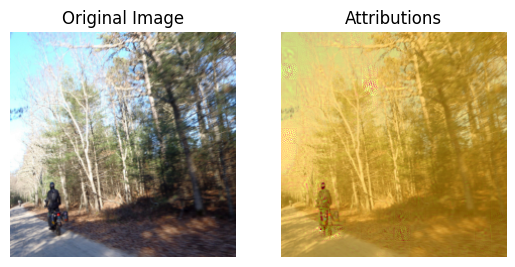

Elapsed time: 4.03 minutes


In [ ]:
# %pip install captum==0.6.0

import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast
from PIL import Image
from captum.attr import IntegratedGradients, visualization
import matplotlib.pyplot as plt
import numpy as np
import time

def main():
    # Check GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    device = 'cpu'
    start_time = time.time()

    # Load pre-trained model and tokenizer
    feature_extractor = ViTImageProcessor.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
    model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
    tokenizer = GPT2TokenizerFast.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

    model = model.to(device)
    print('Moved model to NVIDIA GeForce RTX 3060 Ti\n')

    # Set the model to evaluation mode
    model.eval()
    model.zero_grad()

    # Load and preprocess the image
    image_path = './000000000979.jpg'
    image = Image.open(image_path)
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values

    print(f'Shape of input: {pixel_values.shape}')

    # Move the pixel values to the model's device
    pixel_values = pixel_values.to(device)

    # Define the function to get the output logits
    def forward_func(pixel_values):
        decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device)
        outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)
        logits = outputs.logits[:, -1, :]
        # print(logits.shape)
        return logits

    # Generate the caption
    output_ids = model.generate(pixel_values, max_new_tokens=50)
    output_caption = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

    print(f'Generated Caption: {output_caption}')

    # Integrated Gradients
    integrated_gradients = IntegratedGradients(forward_func)

    # Compute the attributions with reduced steps
    try:
        attributions = integrated_gradients.attribute(inputs=pixel_values, target=0, n_steps=20)
    except Exception as e:
        print(f"Error during attribution computation: {e}")
        return

    # Visualize the attribution
    attribution_image = attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    original_image = pixel_values[0].cpu().detach().numpy().transpose(1, 2, 0)


    # Rescale images to [0, 1] for visualization
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    attribution_image = (attribution_image - attribution_image.min()) / (attribution_image.max() - attribution_image.min())

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(original_image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(original_image)
    # ax[1].imshow(attribution_image, cmap='blended_heat_map', alpha=0.5)
    ax[1].axis('off')
    ax[1].set_title('Attributions')


    gray_attributions = np.mean(attribution_image, axis=2)
    ax[1].imshow(gray_attributions, cmap='hot', alpha=0.5)
    plt.show()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Elapsed time: {elapsed_time / 60:.2f} minutes')

    # _ = visualization.visualize_image_attr(attribution_image, original_image, method="blended_heat_map",
    #                                        sign="positive", show_colorbar=True,
    #                                        title="Integrated Gradients Attribution")

if __name__ == "__main__":
    main()
